In [1]:
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from SSP.networks.ssp import ssp
from tqdm import tqdm
import clip
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
dataset = 'sdv5'
os.makedirs(f'./weights/{dataset}', exist_ok=True)
os.makedirs(f'./results/{dataset}', exist_ok=True)

In [4]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

clip_model.float()
model = ssp().cuda()

In [5]:
train_path = f'./data/{dataset}/train'

train_folder = datasets.ImageFolder(root=train_path, transform=preprocess)

train_folder, val_folder = random_split(train_folder, [0.8, 0.2])

train_loader = DataLoader(train_folder, batch_size=16, shuffle=True)
val_loader = DataLoader(val_folder, batch_size=16, shuffle=False)

In [6]:
num_epochs = 10

optimizer = torch.optim.Adam(model.parameters(), 1e-5)

loss_fn = torch.nn.BCEWithLogitsLoss()

result = []

In [7]:
min_val_loss = float('inf')

for epoch in range(num_epochs):
    
    with tqdm(total=len(train_loader), desc=f'Train Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        model.train()
        running_loss = 0.0
        correct = 0
        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            preds = model(images).ravel()
            loss = loss_fn(preds, labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predictions = torch.sigmoid(preds) > 0.5
            correct += (predictions == labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss/(batch+1)})
            pbar.update()
            
        train_loss = running_loss/len(train_loader)
        train_acc = correct/len(train_loader.dataset)*100
        pbar.set_postfix({'loss': train_loss, 'acc': train_acc})
    
    with tqdm(total=len(val_loader), desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        model.eval()
        with torch.inference_mode():
            running_loss = 0.0
            correct = 0
            for batch, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                preds = model(images).ravel()
                
                running_loss += loss_fn(preds, labels.float()).item()
                predictions = torch.sigmoid(preds) > 0.5
                correct += (predictions == labels).sum().item()
                
                pbar.set_postfix({'loss': running_loss/(batch+1)})
                pbar.update()
                
        val_loss = running_loss/len(val_loader)
        val_acc = correct/len(val_loader.dataset)*100
        pbar.set_postfix({'loss': val_loss, 'acc': val_acc})
                
    result.append({'epoch': epoch+1, 'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})
    result_df = pd.DataFrame(result)
    result_df.to_csv(f'./results/{dataset}/ssp.csv', index=False)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), f'./weights/{dataset}/ssp.pth')

Validation Epoch 10/10: 100%|██████████| 50/50 [00:09<00:00,  5.14batch/s, loss=0.388, acc=86.9]


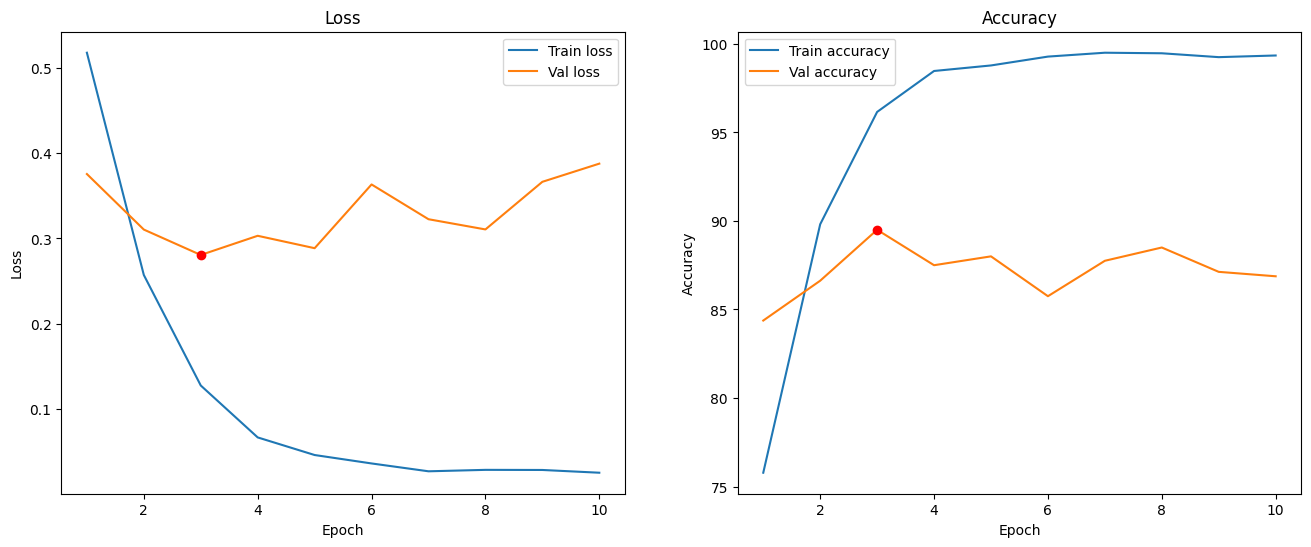

In [8]:
result = pd.read_csv(f'./results/{dataset}/ssp.csv')

min_val_loss = float('inf')
for _, row in result.iterrows():
    if row['val_loss'] < min_val_loss:
        min_val_loss = row['val_loss']
        min_val_loss_row = row
        
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(result['epoch'], result['train_loss'], label='Train loss')
ax[0].plot(result['epoch'], result['val_loss'], label='Val loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_xticks(result['epoch'][1::2])
ax[0].plot(min_val_loss_row['epoch'], min_val_loss_row['val_loss'], 'ro')
ax[0].legend()

ax[1].plot(result['epoch'], result['train_acc'], label='Train accuracy')
ax[1].plot(result['epoch'], result['val_acc'], label='Val accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_xticks(result['epoch'][1::2])
ax[1].plot(min_val_loss_row['epoch'], min_val_loss_row['val_acc'], 'ro')
ax[1].legend()